In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime

In [5]:
train = pd.read_csv('train_c.csv',parse_dates=['timestamp'])
test = pd.read_csv('test_c.csv',parse_dates=['timestamp'])

In [8]:
def quarter_cal(Month):
    if Month>=1 and Month <=3:
        return 'Q1'
    elif Month >3 and Month <=6:
        return 'Q2'
    elif Month >6 and Month <=9:
        return 'Q3'
    else:
        return 'Q4'

In [9]:
train_quarter = [str(x)+quarter_cal(y) for x,y in zip(list(train.timestamp.dt.year),list(train.timestamp.dt.month))]
test_quarter = [str(x)+quarter_cal(y) for x,y in zip(list(test.timestamp.dt.year),list(test.timestamp.dt.month))]

In [10]:
train['Quarter'] = train_quarter
test['Quarter'] = test_quarter

In [11]:
quarter_data = pd.read_csv('Quaterly Data.csv',sep=';')[['Quarter','Primary Average']]
train = train.merge(quarter_data,on='Quarter',how='left')
test = test.merge(quarter_data,on='Quarter',how='left')
del train['Quarter']
del test['Quarter']

In [12]:
col = list(test.columns)[2:]
label = train['price_doc']*0.95+10
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

In [13]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.79559e+06	test-rmse:7.79999e+06
[50]	train-rmse:2.38813e+06	test-rmse:2.74676e+06
[100]	train-rmse:2.07548e+06	test-rmse:2.57996e+06
[150]	train-rmse:1.95466e+06	test-rmse:2.5413e+06
[200]	train-rmse:1.86619e+06	test-rmse:2.51963e+06
[250]	train-rmse:1.79623e+06	test-rmse:2.50642e+06
[300]	train-rmse:1.73532e+06	test-rmse:2.49987e+06
[350]	train-rmse:1.68096e+06	test-rmse:2.49446e+06
Performance does not improve from 366 rounds


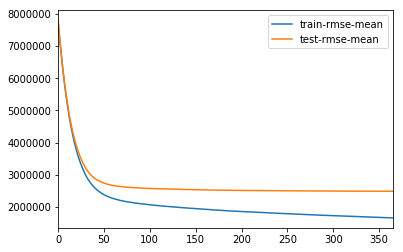

In [14]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [15]:
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [16]:
pred = model.predict(dtest)

In [17]:
sub = pd.DataFrame({'id':test['id'],'price_doc':pred})
sub.to_csv('Sub_BestSingle_With_AvePrice.csv',index=False)